# DCGAN in Dog vs Cat Dataset

## Library Call & Setting

In [1]:
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import numpy as np
import os
import PIL
import shutil
import random
import zipfile
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.utils as utils
import torchvision.datasets as datasets
import torchvision.transforms as transforms

GPU

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

HyperParemeter

In [3]:
seed = 42
n = 5000
pix = 128

# generator & discriminator
ngpu = 1 # number of gpu's available
nc = 3   # number of image channels
nf = 32  # number of generator & discriminator filters
nz = 100 # number of input noise dimension

# train
lr = 0.0002
beta1 = 0.5
batch_size = 50
num_workers = 2
epochs = 500

Randomness Control

In [4]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if device == 'cuda':
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Data Load

`Dogs. vs Cats.` dataset download link:

https://www.kaggle.com/c/dogs-vs-cats/data

In your working directory, there should be a `train.zip`.

In [5]:
train_dir = os.path.join(os.getcwd(), 'train') # ./train : Original train dataset
gan_dir = os.path.join(os.getcwd(), 'gan')     # ./gan : To use ImageFolder in torchvision.datasets
dog_dir = os.path.join(gan_dir, 'dog')         # ./gan/dog : Images to train GAN model

In [6]:
# train dir
if os.path.isdir(train_dir) and len(os.listdir(train_dir)) == 25000:
    print("It's already set up!")
else:
    train_zip_dir = os.path.join(os.getcwd(), 'train.zip')
    with zipfile.ZipFile(train_zip_dir, 'r') as z:
        z.extractall()
    print("Done.")

It's already set up!


In [7]:
# gan_dir
if os.path.isdir(gan_dir):
    print("It's already set up!")
else:    
    os.mkdir(gan_dir)
    print("Done.")

It's already set up!


In [8]:
# dog_dir
if os.path.isdir(dog_dir) and len(os.listdir(dog_dir)) > 0:
    print("It's already set up!")
else:    
    os.mkdir(dog_dir)
    dog_files = [f'dog.{i}.jpg' for i in range(n)]
    for dog in dog_files:
        src = os.path.join(train_dir, dog)
        dst = os.path.join(dog_dir, dog)
        shutil.copy(src, dst)
    print("Done.")

It's already set up!


In [9]:
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((pix, pix)),
                                            torchvision.transforms.ToTensor()])

dataset = datasets.ImageFolder(gan_dir, transform=transform)
print(len(dataset))

5000


## GAN

### Training Setting

#### Weight Initialization

In [10]:
def initialize_weights(model):
    class_names = model.__class__.__name__

    if class_names.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)

    elif class_names.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

#### Generator

$${o = (i-1)*s +k-2p}$$

In [11]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # batch_size x nz    x   1 x   1
            nn.ConvTranspose2d(nz   , nf*16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(nf*16),
            nn.ReLU(True),
            # batch_size x nf*16 x   4 x   4
            nn.ConvTranspose2d(nf*16, nf*8 , 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf*8),
            nn.ReLU(True),
            # batch_size x nf*8  x   8 x   8
            nn.ConvTranspose2d(nf*8 , nf*4 , 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf*4),
            nn.ReLU(True),
            # batch_size x nf*4  x  16 x  16
            nn.ConvTranspose2d(nf*4 , nf*2 , 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf*2),
            nn.ReLU(True),
            # batch_size x nf*2  x  32 x  32
            nn.ConvTranspose2d(nf*2 , nf   , 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf),
            nn.ReLU(True),
            # batch_size x nf    x  64 x  64
            nn.ConvTranspose2d(nf   , nc   , 4, 2, 1, bias=False),
            nn.Tanh()
            # batch_size x nc    x 128 x 128
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

G = Generator(ngpu).to(device)
G.apply(initialize_weights)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(

#### Discriminator

$$o = {i -k +2p \over s } + 1$$

In [12]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # batch_size x nc    x 128 x 128
            nn.Conv2d(nc    , nf   , 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf),
            nn.LeakyReLU(0.2, inplace=True),
            # batch_size x nf    x  64 x  64
            nn.Conv2d(nf   , nf*2 , 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf*2),
            nn.LeakyReLU(0.2, inplace=True),
            # batch_size x nf*2  x  32 x  32
            nn.Conv2d(nf*2 , nf*4 , 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf*4),
            nn.LeakyReLU(0.2, inplace=True),
            # batch_size x nf*4  x  16 x  16
            nn.Conv2d(nf*4 , nf*8 , 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf*8),
            nn.LeakyReLU(0.2, inplace=True),
            # batch_size x nf*8  x   8 x   8
            nn.Conv2d(nf*8 , nf*16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf*16),
            nn.LeakyReLU(0.2, inplace=True),
            # batch_size x nf*16 x   4 x   4
            nn.Conv2d(nf*16, 1    , 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output.view(-1)

D = Discriminator(ngpu).to(device)
D.apply(initialize_weights)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(256, 512, kernel_size=(4

#### Loss Function & Optimizer

In [13]:
criterion = nn.BCELoss() # BCE_Loss(D(x), y): -y*log(D(x)) -(1-y)*log(1 - D(x))
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=[beta1, 0.999])
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr, betas=[beta1, 0.999])

### Training

In [14]:
data_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=num_workers)

fixed_noise = torch.randn(batch_size, nz, 1, 1).to(device)
real_labels = torch.ones(batch_size).to(device)
fake_labels = torch.zeros(batch_size).to(device)

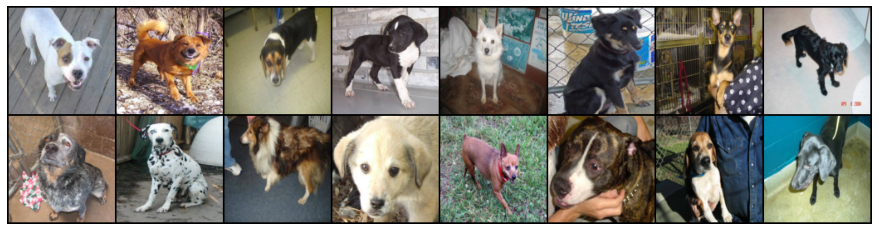

In [15]:
def imshow_grid(img):
    img = utils.make_grid(img.cpu().detach())
    npimg = img.numpy()
    plt.figure(figsize=(20, 4))
    plt.imshow((np.transpose(npimg, (1, 2, 0)) * 255).astype(np.uint8))
    plt.axis('off')
    plt.show()

samples, _ = next(iter(data_loader))
imshow_grid(samples[:16, :, :])

In [1]:
# epochs_done = int(input())
# G.load_state_dict(torch.load(f'./pth/DCGAN_G_e{epochs_done}_p{pix}_f{nf}.pth'))
# D.load_state_dict(torch.load(f'./pth/DCGAN_D_e{epochs_done}_p{pix}_f{nf}.pth'))

In [ ]:
for epoch in range(1, epochs+1):
    for images, labels in tqdm(data_loader):

        # Discriminator
        D.zero_grad()
        x_real = images.to(device)
        D_real = D(x_real)
        D_loss_real = criterion(D_real, real_labels)

        z = torch.randn(batch_size, nz, 1, 1).to(device)
        x_fake = G(z)
        D_fake = D(x_fake.detach())
        D_loss_fake = criterion(D_fake, fake_labels)
        
        D_loss = D_loss_real + D_loss_fake
        
        D_loss.backward()
        D_optimizer.step()
        
        # Generator
        G.zero_grad()
        x_fake = G(z)
        D_fake = D(x_fake)
        G_loss = criterion(D_fake, real_labels)
        
        G_loss.backward()
        G_optimizer.step()
           
    print(f"Epoch [{epoch}/{epochs}]")
    print(f"D_loss: {D_loss.item():.4f}, G_loss: {G_loss.item():.4f}")
    
    if epoch % 100 == 0:
        torch.save(G.state_dict(), f'./pth/DCGAN_G_e{epoch}_p{pix}_f{nf}.pth')
        torch.save(D.state_dict(), f'./pth/DCGAN_D_e{epoch}_p{pix}_f{nf}.pth')       
        
    fake = G(fixed_noise)
    imshow_grid(fake[:16, :, :])

### Result

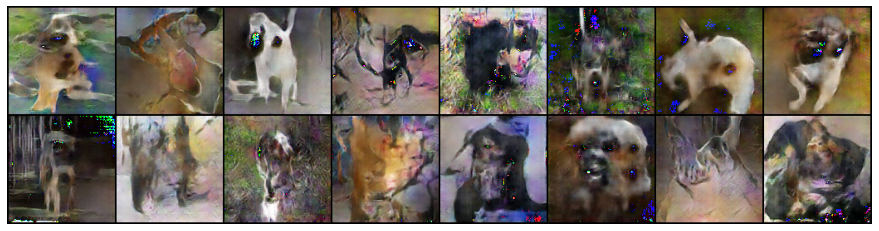

In [19]:
new_noise = torch.randn(16, nz, 1, 1).to(device)
fake = G(new_noise)
imshow_grid(fake[:16, :, :])